# CESCO Q&A를 통한 가정집 해충 조사

* 세스코 홈페이지에 등록된 26330개 QnA의 데이터 수집 및 분석
* QnA에서 보통 다루는 내용은 해충의 사진을 업로드하고 해충의 이름을 묻는 유형이 많음을 발견하여 사진을 업로드한 QnA 데이터만을 수집
* Url의 규칙성을 발견하여 iterative하게 페이지를 순회하며 데이터를 수집
* 2010년대부터의 데이터를 조사하느라 중간에 홈페이지 업데이트로 인해 웹페이지 형식이 바뀌었음 -> 예외처리를 통해 해결
* 또한 에러를 해결할때마다 처음부터 다시 크롤링하는 것은 비효율적이라 생각했기 때문에 데이터베이스를 계속 체크하며 한번 크롤링한 데이터는 건너뛰도록 구현

In [43]:
!pip install beautifulsoup4
!pip install wget
!pip install pandas
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 10.3 MB 5.5 MB/s            
     |████████████████████████████████| 1.2 MB 18.4 MB/s            


In [2]:
#from selenium import webdriver
from bs4 import BeautifulSoup
import requests
import pandas as pd


import urllib3, shutil
import math
import os

In [3]:
# base url
base_url = 'https://cesco.co.kr/Cesco/support/'
base_list_url = 'https://cesco.co.kr/Cesco/support/support_qna_list.aspx?Page='
base_download = 'https://cesco.co.kr'

# for image download
pool_manager = urllib3.PoolManager()

In [4]:
# for dataframe
QnA_number = []
Question = []
Question_url = []
Answer = []
Answer_url = []

In [6]:
# get num of list and num of page number
req = requests.get('https://cesco.co.kr/Cesco/support/support_qna_list.aspx?Page=1')
soup = BeautifulSoup(req.text, 'html.parser')
all_links = soup.select('td.borLNone.cor_999')

# 총 질문의 개수를 찾음
num_of_links = int(all_links[0].get_text())

# QnA리스트가 있는 페이지를 불러옴
for page_num in range(1, math.ceil(num_of_links/10)+1):
    # page url & QnA number parsing
    cur_page_url = base_list_url + str(page_num)
    req = requests.get(cur_page_url)
    soup = BeautifulSoup(req.text, 'html.parser')
    inform_page_links = soup.select('a.list_link')
    QnA_Nos = soup.select('td.borLNone.cor_999')

    # 각 QnA 페이지에 접속
    for link,QnA_no in zip(inform_page_links, QnA_Nos):
        try:
            is_download = True
            if QnA_no.get_text() in QnA_number:
                print(QnA_no.get_text() + "번은 이미 DB에 존재합니다.")
                continue

            req = requests.get(base_url + link['href'])
            try :
                soup = BeautifulSoup(req.text, 'html.parser')
            except:
                print(QnA_no.get_text() +"번 soup 생성 실패")
                continue

            # 질문을 가져옴
            value = soup.find('td', 'borLNone view_con')
            question = [line for line in value.get_text().replace("\xa0", "").split('\n') if line != '']

            # 질문 이미지 저장
            question_img_url = []
            find_img = value.find_all('img')
            for value in find_img:
                question_img_url.append(value['src'])

            # 질문 이미지가 없으면 건너 뜀
            if len(question_img_url) == 0:
                print(QnA_no.get_text() + "번 문제는 건너뜁니다.(질문 이미지 없음)")
                continue

            for idx, url in enumerate(question_img_url):
                # 사진을 상대경로로 저장한 경우 full url로 변환
                if url.find("http") == -1 :
                    url = base_download + url

                # 이미지 이름 설정 후 저장
                image_name = None
                if len(question_img_url) > 1:
                    image_name = QnA_no.get_text() + "-"+ str(idx+1) + "." + url.split(".")[-1] # 확장자 처리
                else:
                    image_name = QnA_no.get_text() + "." + url.split(".")[-1] # 확장자 처리
                try:
                    img_path = os.path.join(os.getcwd(),"images", image_name)
                    with pool_manager.request('GET', url, preload_content=False) as res, open(img_path, 'wb') as out_file:
                        shutil.copyfileobj(res, out_file)
                except:
                    print(QnA_no.get_text()+"번 문제 다운로드 실패했습니다.(question)")
                    is_download = False
                    break

            # 답변을 가져옴
            value = soup.find('td', 'cor_555 lineH15 scroll_box')
            answer = [line for line in value.get_text().replace("\xa0", "").split('\n') if line != '']

            # 답변 이미지 저장
            answer_img_url = []
            find_img = value.find_all('img')
            for value in find_img:
                answer_img_url.append(value['alt'])

            for idx, url in enumerate(answer_img_url):
                # 사진을 상대경로로 저장한 경우 full url로 변환
                if url.find("http") == -1 :
                    url = base_download + url

                image_name = None
                if len(answer_img_url) > 1:
                    image_name = "ans_" + QnA_no.get_text() + "-"+ str(idx+1) + "." + url.split(".")[-1] # 확장자 처리
                else:
                    image_name = "ans_" + QnA_no.get_text() + "." + url.split(".")[-1] # 확장자 처리
                try:
                    img_path = os.path.join(os.getcwd(),"images", image_name)
                    with pool_manager.request('GET', url, preload_content=False) as res, open(img_path, 'wb') as out_file:
                        shutil.copyfileobj(res, out_file)
                except:
                    print(QnA_no.get_text()+"번 문제 다운로드 실패했습니다.(ans)")
                    is_download = False
                    break

            # 이미지를 다운로드에 실패한 경우 데이터에 추가하지 않음
            if is_download:
                print(QnA_no.get_text() + "번 문제를 처리중 입니다.")
                QnA_number.append(QnA_no.get_text())
                Question.append("\n".join(question))
                Question_url.append("\n".join(question_img_url))
                Answer.append("\n".join(answer))
                Answer_url.append("\n".join(answer_img_url))
        except:
            print(QnA_no.get_text()+"번 문제 다운로드 실패했습니다.(이유 미상)")

26330번은 이미 DB에 존재합니다.
26329번은 이미 DB에 존재합니다.
26328번 문제는 건너뜁니다.(질문 이미지 없음)
26327번은 이미 DB에 존재합니다.
26326번 문제는 건너뜁니다.(질문 이미지 없음)
26325번은 이미 DB에 존재합니다.
26324번 문제는 건너뜁니다.(질문 이미지 없음)
26323번은 이미 DB에 존재합니다.
26322번은 이미 DB에 존재합니다.
26321번 문제는 건너뜁니다.(질문 이미지 없음)
26320번 문제는 건너뜁니다.(질문 이미지 없음)
26319번은 이미 DB에 존재합니다.
26318번은 이미 DB에 존재합니다.
26317번은 이미 DB에 존재합니다.
26316번은 이미 DB에 존재합니다.
26315번은 이미 DB에 존재합니다.
26314번은 이미 DB에 존재합니다.
26313번은 이미 DB에 존재합니다.
26312번은 이미 DB에 존재합니다.
26311번 문제는 건너뜁니다.(질문 이미지 없음)
26310번 문제는 건너뜁니다.(질문 이미지 없음)
26309번은 이미 DB에 존재합니다.
26308번은 이미 DB에 존재합니다.
26307번은 이미 DB에 존재합니다.
26306번은 이미 DB에 존재합니다.
26305번은 이미 DB에 존재합니다.
26304번은 이미 DB에 존재합니다.
26303번은 이미 DB에 존재합니다.
26302번은 이미 DB에 존재합니다.
26301번은 이미 DB에 존재합니다.
26300번은 이미 DB에 존재합니다.
26299번은 이미 DB에 존재합니다.
26298번은 이미 DB에 존재합니다.
26297번은 이미 DB에 존재합니다.
26296번은 이미 DB에 존재합니다.
26295번은 이미 DB에 존재합니다.
26294번은 이미 DB에 존재합니다.
26293번은 이미 DB에 존재합니다.
26292번은 이미 DB에 존재합니다.
26291번은 이미 DB에 존재합니다.
26290번은 이미 DB에 존재합니다.
26289번은 이미 DB에 존재합니다.
26288번은 이미 DB에 존재합니다.
26287

In [8]:
df = pd.DataFrame(zip(QnA_number,Question,Question_url,Answer, Answer_url), columns=["Question.No", "Question", "question_picture_url","Answer", "answer_picture_url"])

In [10]:
df.head(100)

,Question.No,질문 내용,질문 사진 url,답변 내용,답변 사진 url
0,26330,혹시 이벌레가 뭘까요?\n미세먼지방충망을 했는데도 집에 이 벌레가 있어서요ㅠㅠ,https://www.cesco.co.kr/userfiles/image/202110...,"코마로브집게벌레가 야산 등지에서 주로 서식하다가 월동을 위해 자리를 찾게 되는데,\...",http://www.cesco.co.kr/userfiles/image/window.jpg
1,26329,\r\n\t\t\t\t\t\t\t\t\t무슨 벌레의 알일까요? 사진에서 보이는 바와...,https://www.cesco.co.kr/userfiles/image/202110...,보통은 나방류가 이렇게 산란하고 보호막을 씌워놓기는 하지만 알기 어렵습니다.\n정히...,
2,26327,벌레 종류가 궁금해서 문의드립니다.\r\n\t\t\t\t\t\t\t\t,https://www.cesco.co.kr/userfiles/image/202110...,좀벌레로 확인됩니다.\n좀벌레는 습도를 체내에 보관할 수 없기 때문에 항상 습도가 ...,
3,26325,\r\n\t\t\t\t\t\t\t\t\t안녕하세요?\r\n\r\n2주일 전에 현재 ...,https://www.cesco.co.kr/userfiles/image/202110...,실지렁이로 사료됩니다.\n화장실로 실지렁이가 들어오는 경로는 두 가지로\n벽면 틈새...,
4,26323,실제크기는 깨만한데 바퀴벌레 유충일까요? 한 달 반 사이 갈색 바퀴벌레 3마리를 발...,https://www.cesco.co.kr/userfiles/image/202110...,"사진을 보니, 벼룩파리로 사료됩니다.\n여름철에 실내에서 가장 많이 목격되는 벌레 ...",
...,...,...,...,...,...
95,26215,안녕하세요.\n해충관련 문의 드립니다.\n*발견횟 수 \n1) 화장실 주변에서 한번...,https://www.cesco.co.kr/userfiles/image/202107...,귀뚜라미로 사료됩니다.\n방충망 없이 개방된 창문으로 침입했을 수 있고\n출입문 하...,http://www.cesco.co.kr/userfiles/image/window.jpg
96,26214,\r\n\t\t\t\t\t\t\t\t\t집 거실에 이런 놈이 여러마리가 있는데\r\...,https://www.cesco.co.kr/userfiles/image/202107...,"다리가 보이지 않고, \n몸체가 원추형으로 전방으로 갈수록 가늘어지는 것을 볼 때,...",
97,26213,안녕하세요!!! 때마다 도움 주셔서 감사합니다!!!!\n어제 밥 먹고 치우려는데 식...,https://www.cesco.co.kr/userfiles/image/202107...,사진이라 불분명 하나 잎벌레류로 사료됩니다. \n잎벌레류는 성충과 유충이 잎이나 ...,http://www.cesco.co.kr/userfiles/image/window.jpg
98,26212,저 초록색 뭉탱이로 있는 애들 있죠? 지난주부터인가 조금씩 보이길래 무시하고 있었읍...,https://www.cesco.co.kr/userfiles/image/202107...,사진으로 명확하지 않아 바퀴벌레 유무 확인도 어려운 상태입니다.\n다만 색상이나 크...,http://www.cesco.co.kr/userfiles/image/window.jpg


In [2]:
df.to_csv("dataset.csv",mode="w")

## 수집된 데이터로 데이터 시각화와 간단한 가설 제시
* 가설: 질문이 길 수록 답변도 길 것이다.

In [10]:
import pandas as pd
df = pd.read_csv("dataset.csv")

In [12]:
df.head()

,Unnamed: 0,Question.No,질문 내용,질문 사진 url,답변 내용,답변 사진 url
0,0.0,26330,혹시 이벌레가 뭘까요?\n미세먼지방충망을 했는데도 집에 이 벌레가 있어서요ㅠㅠ,https://www.cesco.co.kr/userfiles/image/202110...,"코마로브집게벌레가 야산 등지에서 주로 서식하다가 월동을 위해 자리를 찾게 되는데,\...",http://www.cesco.co.kr/userfiles/image/window.jpg
1,1.0,26329,\r\n\t\t\t\t\t\t\t\t\t무슨 벌레의 알일까요? 사진에서 보이는 바와...,https://www.cesco.co.kr/userfiles/image/202110...,보통은 나방류가 이렇게 산란하고 보호막을 씌워놓기는 하지만 알기 어렵습니다.\n정히...,NaN
2,2.0,26327,벌레 종류가 궁금해서 문의드립니다.\r\n\t\t\t\t\t\t\t\t,https://www.cesco.co.kr/userfiles/image/202110...,좀벌레로 확인됩니다.\n좀벌레는 습도를 체내에 보관할 수 없기 때문에 항상 습도가 ...,NaN
3,3.0,26325,\r\n\t\t\t\t\t\t\t\t\t안녕하세요?\r\n\r\n2주일 전에 현재 ...,https://www.cesco.co.kr/userfiles/image/202110...,실지렁이로 사료됩니다.\n화장실로 실지렁이가 들어오는 경로는 두 가지로\n벽면 틈새...,NaN
4,4.0,26323,실제크기는 깨만한데 바퀴벌레 유충일까요? 한 달 반 사이 갈색 바퀴벌레 3마리를 발...,https://www.cesco.co.kr/userfiles/image/202110...,"사진을 보니, 벼룩파리로 사료됩니다.\n여름철에 실내에서 가장 많이 목격되는 벌레 ...",NaN


In [31]:
# 필요한 열들을 제외하고 모두 제거
processed_df = df[['질문 내용', '답변 내용']]
print(len(processed_df))

5154


In [35]:
# 결측치 제거
processed_df=processed_df.dropna()
print(len(processed_df))

4889


In [36]:
# 쓸모 없는 앞 뒤 공백 삭제
processed_df = processed_df.applymap(lambda x : x.strip())
processed_df.head()

,질문 내용,답변 내용
0,혹시 이벌레가 뭘까요?\n미세먼지방충망을 했는데도 집에 이 벌레가 있어서요ㅠㅠ,"코마로브집게벌레가 야산 등지에서 주로 서식하다가 월동을 위해 자리를 찾게 되는데,\..."
1,무슨 벌레의 알일까요? 사진에서 보이는 바와 같이 털실 같은 것에 감싸져 있었고 뜯...,보통은 나방류가 이렇게 산란하고 보호막을 씌워놓기는 하지만 알기 어렵습니다.\n정히...
2,벌레 종류가 궁금해서 문의드립니다.,좀벌레로 확인됩니다.\n좀벌레는 습도를 체내에 보관할 수 없기 때문에 항상 습도가 ...
3,안녕하세요?\r\n\r\n2주일 전에 현재 아파트로 이사왔습니다.\n근데 안방 화장...,실지렁이로 사료됩니다.\n화장실로 실지렁이가 들어오는 경로는 두 가지로\n벽면 틈새...
4,실제크기는 깨만한데 바퀴벌레 유충일까요? 한 달 반 사이 갈색 바퀴벌레 3마리를 발...,"사진을 보니, 벼룩파리로 사료됩니다.\n여름철에 실내에서 가장 많이 목격되는 벌레 ..."


In [37]:
def count_word(text: str) -> int:
    # 엔터 제거
    text.replace("\r","").replace("\n","")
    return len(text)

In [38]:
# 질문 및 답변의 글자 수 세기
processed_df = processed_df.applymap(count_word)
processed_df.head()

,질문 내용,답변 내용
0,42,497
1,88,200
2,19,592
3,508,500
4,116,564


<AxesSubplot:xlabel='질문 내용', ylabel='답변 내용'>

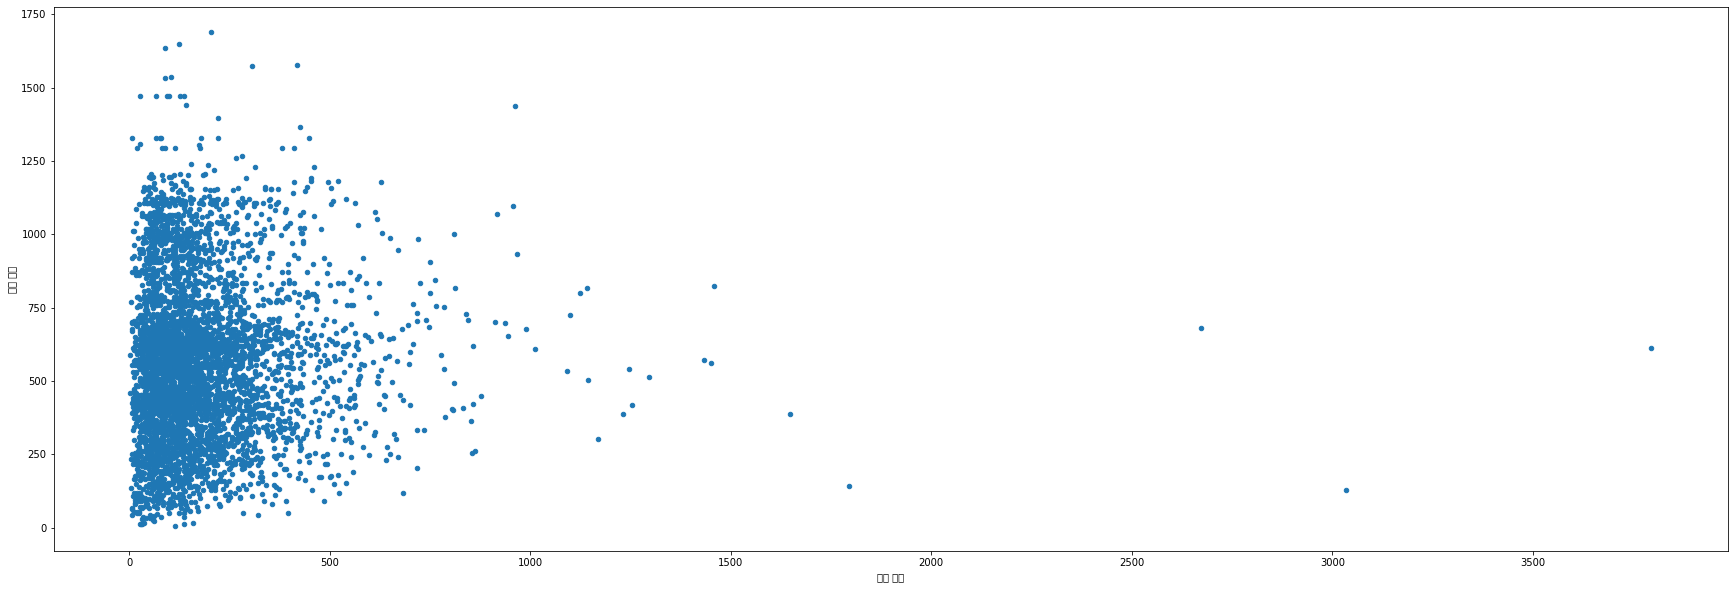

In [48]:
%matplotlib inline
processed_df.plot(kind='scatter', x='질문 내용', y="답변 내용", figsize=(30, 10))

In [50]:
import numpy as np
np.corrcoef(processed_df['질문 내용'], processed_df['답변 내용'])

array([[1.       , 0.0237705],
       [0.0237705, 1.       ]])